In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

2018，2019，2020三年的load变化数据分别是8760，8760，8784个，共有26304。

这三年的数据整合在generate_data_30 bus_all.csv文件中。

通过matpower的结果是bus30_branch_result.csv

branch_info_all_6_load1.5 load变为1.5倍
branch_info_all_6_load1.2 load变为1.2倍
branch_info_all_6_load    load不变
mpc.gen 里面最后一个generator，每15天停1天之后恢复，停的那天使用备用机组，cost变为1.5倍（一次，二次项都变为1.5倍）。

branch_info_all_2_load1.5 load变为1.5倍
branch_info_all_2_load1.2 load变为1.2倍
branch_info_all_2_load    load不变
mpc.gen 里面选择第2个和第6个，每15天停1天之后恢复，停的那天使用备用机组，cost变为1.5倍（一次，二次项都变为1.5倍）。

jiang's idea: 
考虑是否拥堵的前提，规划何时检修，来减少拥堵
意义之一是帮助设计检修的scheduling

In [5]:
now_path = os.getcwd()
os.listdir(now_path + '/../Data/GC')

['branch_info_all_2_load1.2.csv',
 'branch_info_all_6_load1.5.csv',
 '.ipynb_checkpoints',
 'branch_info_all_2_load.csv',
 'branch_info_all_6_load1.2.csv',
 'branch_info_all_6_load.csv',
 'branch_info_all_2_load1.5.csv']

In [17]:
now_path = os.getcwd()

branch_result_path = now_path + '/../Data/' + 'bus30_branch_result.csv' 
branch_result = pd.read_csv(branch_result_path, header=None)

branch_limitation_path = now_path + '/../Data/' + 'bus30_branch_limitation.csv'
branch_limitation = pd.read_csv(branch_limitation_path, header=None)


gc_path = now_path + '/../Data/GC/'
gc_load_path = os.path.join(gc_path, "branch_info_all_6_load.csv")
# gc_load12_path = 
# gc_load15_path = 
# gc_2_load_path = 
# gc_2_load12_path = 
# gc_2_loat15_path = 
gc_load = pd.read_csv(gc_load_path, header=None)[:-1]  #(41, 26304)



line_num = branch_result.shape[0]
sample_num = branch_result.shape[1]

In [21]:
branch_result = gc_load

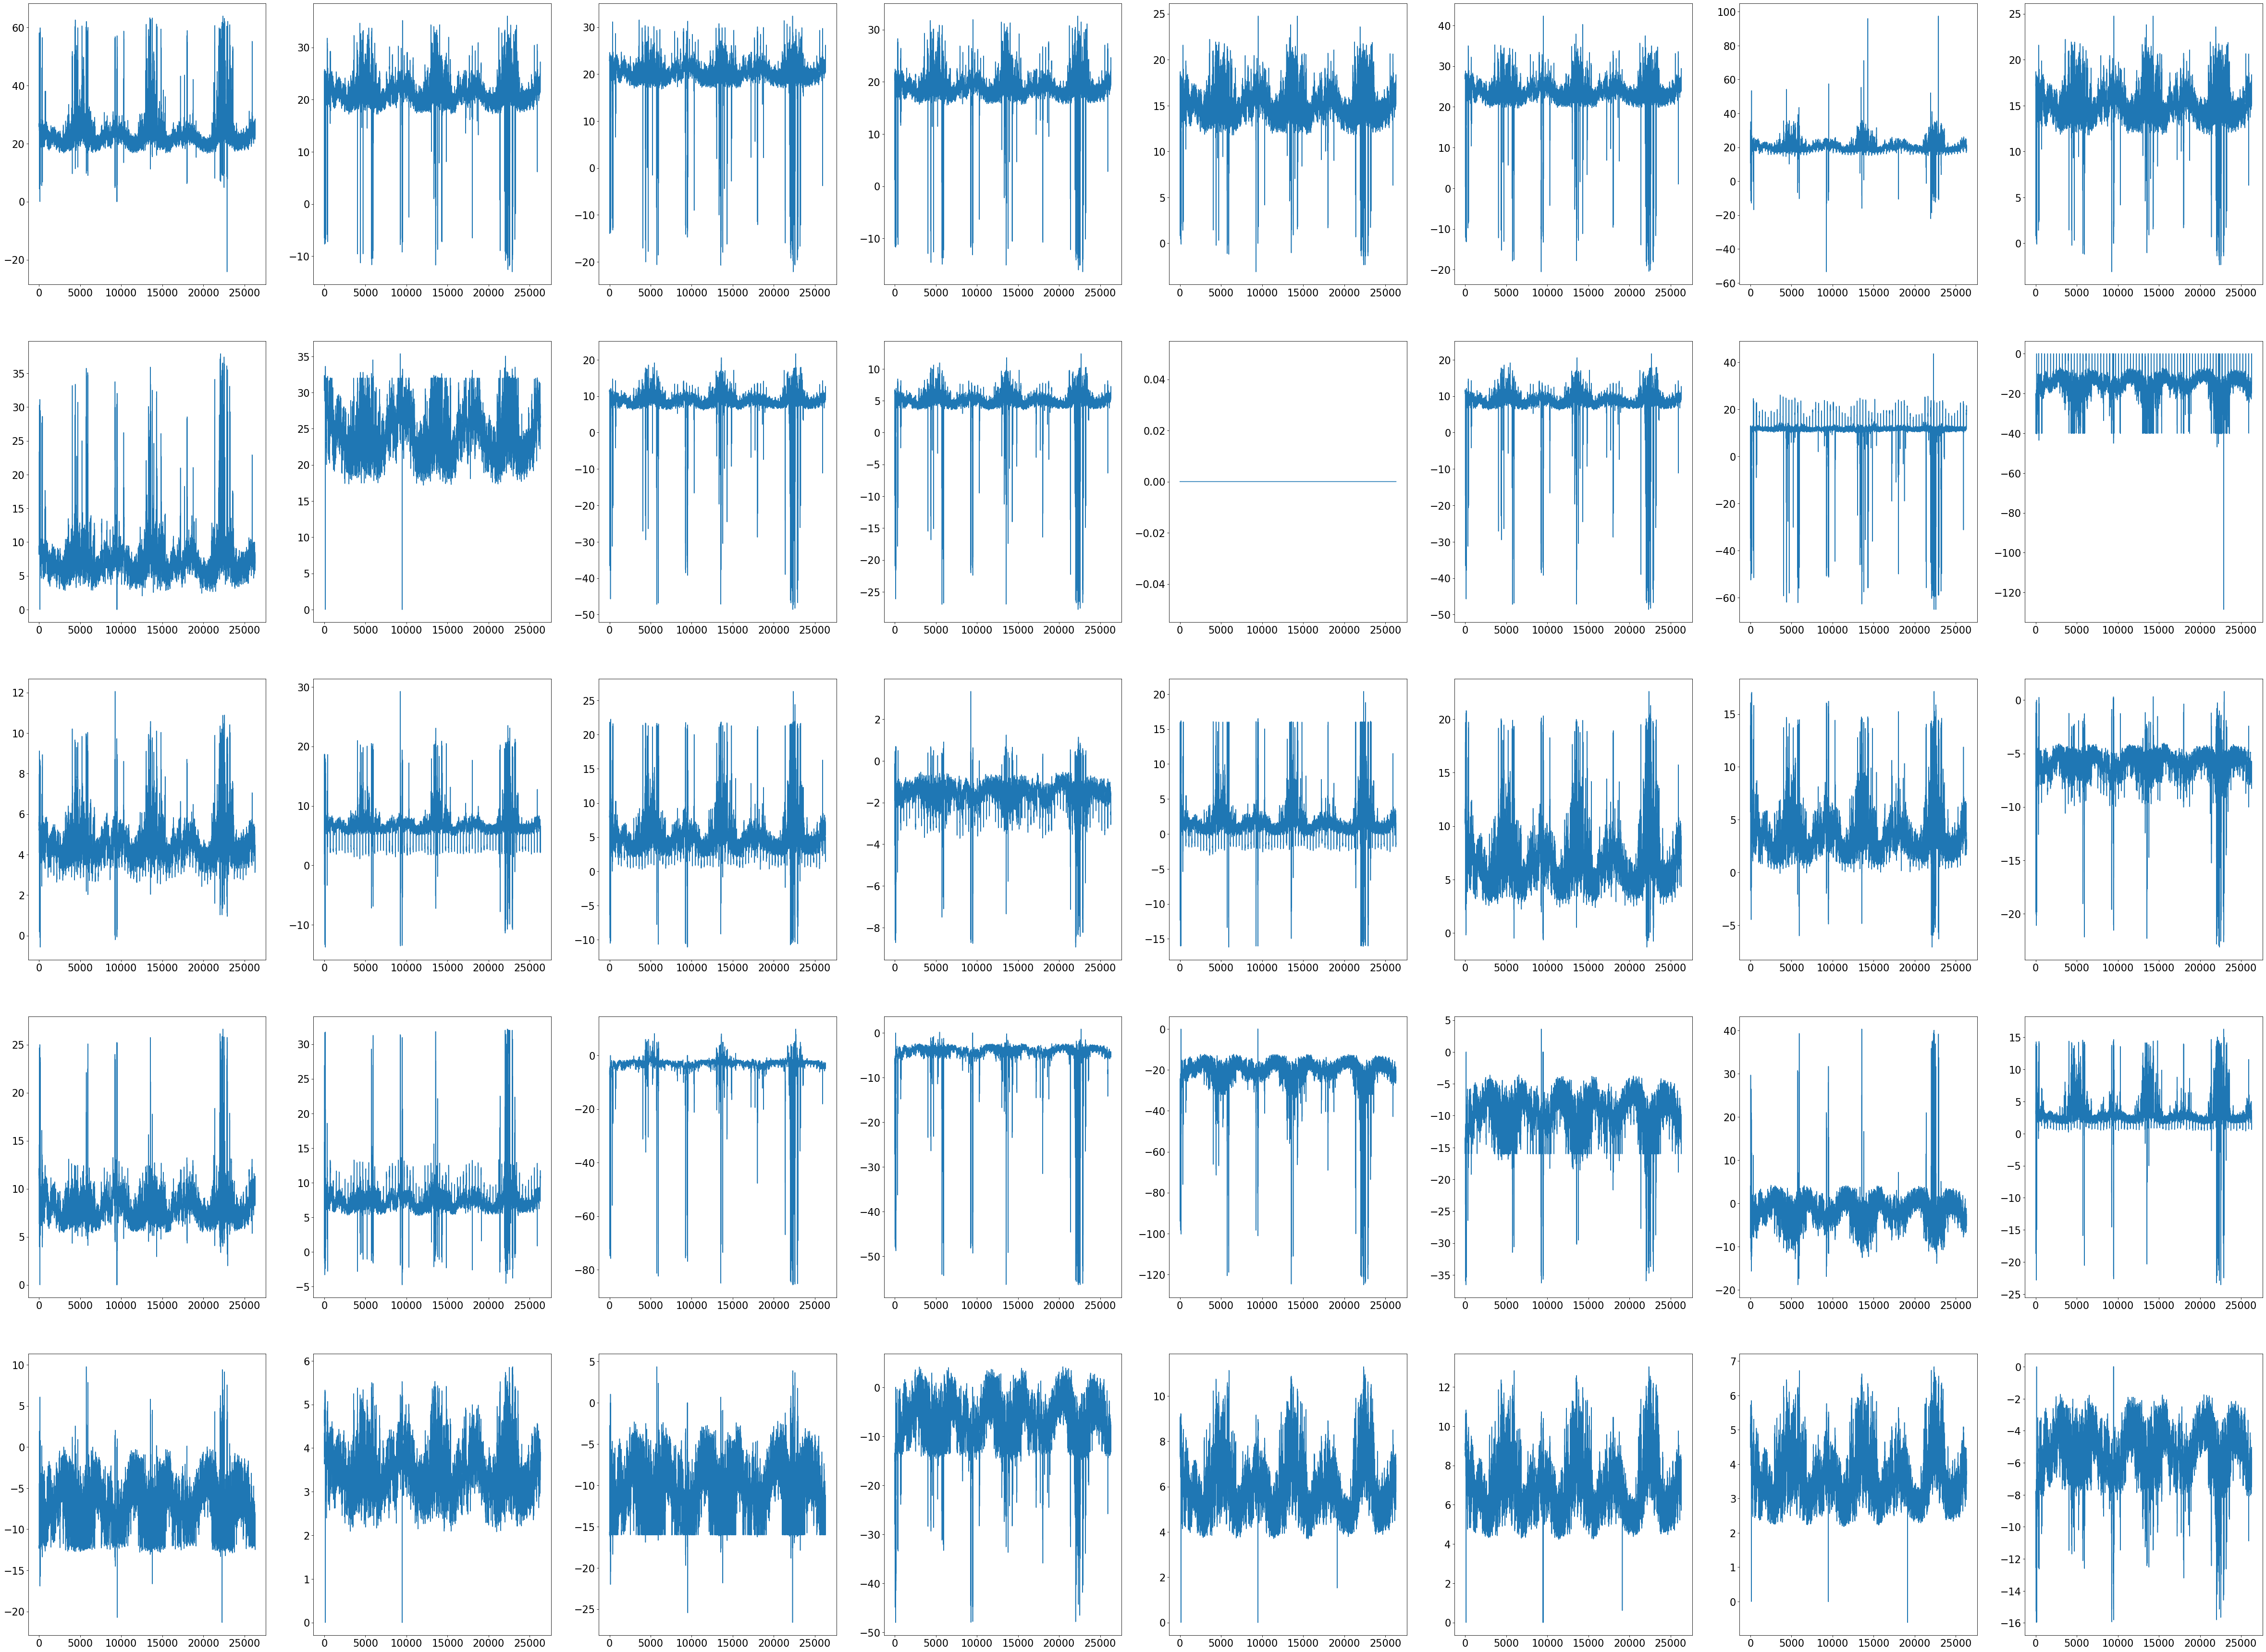

In [22]:
# plot the branch result

fig = plt.figure(figsize=(80, 60), dpi=75)
for i in range(40):
    now = branch_result[i:i+1]
    now = now.to_numpy()[0]
    plt.subplot(5,8,i+1)
    plt.tick_params(labelsize=20)
    plt.plot(now)
plt.show()

### 查看有哪些线路拥堵过

In [23]:
congested_set = set()
congested_point = [[] for i in range(line_num)]
for i in range(line_num):
    now = branch_result[i:i+1]
    now = now.to_numpy()[0]
    now_limit = branch_limitation[0][i]
    for timestamp, flow in enumerate(now):
        if abs(flow) >= now_limit:
            congested_set.add(i)
            congested_point[i].append((timestamp, flow))
print(congested_set)

{32, 34, 6, 40, 9, 15, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31}


### 对拥堵线路可视化

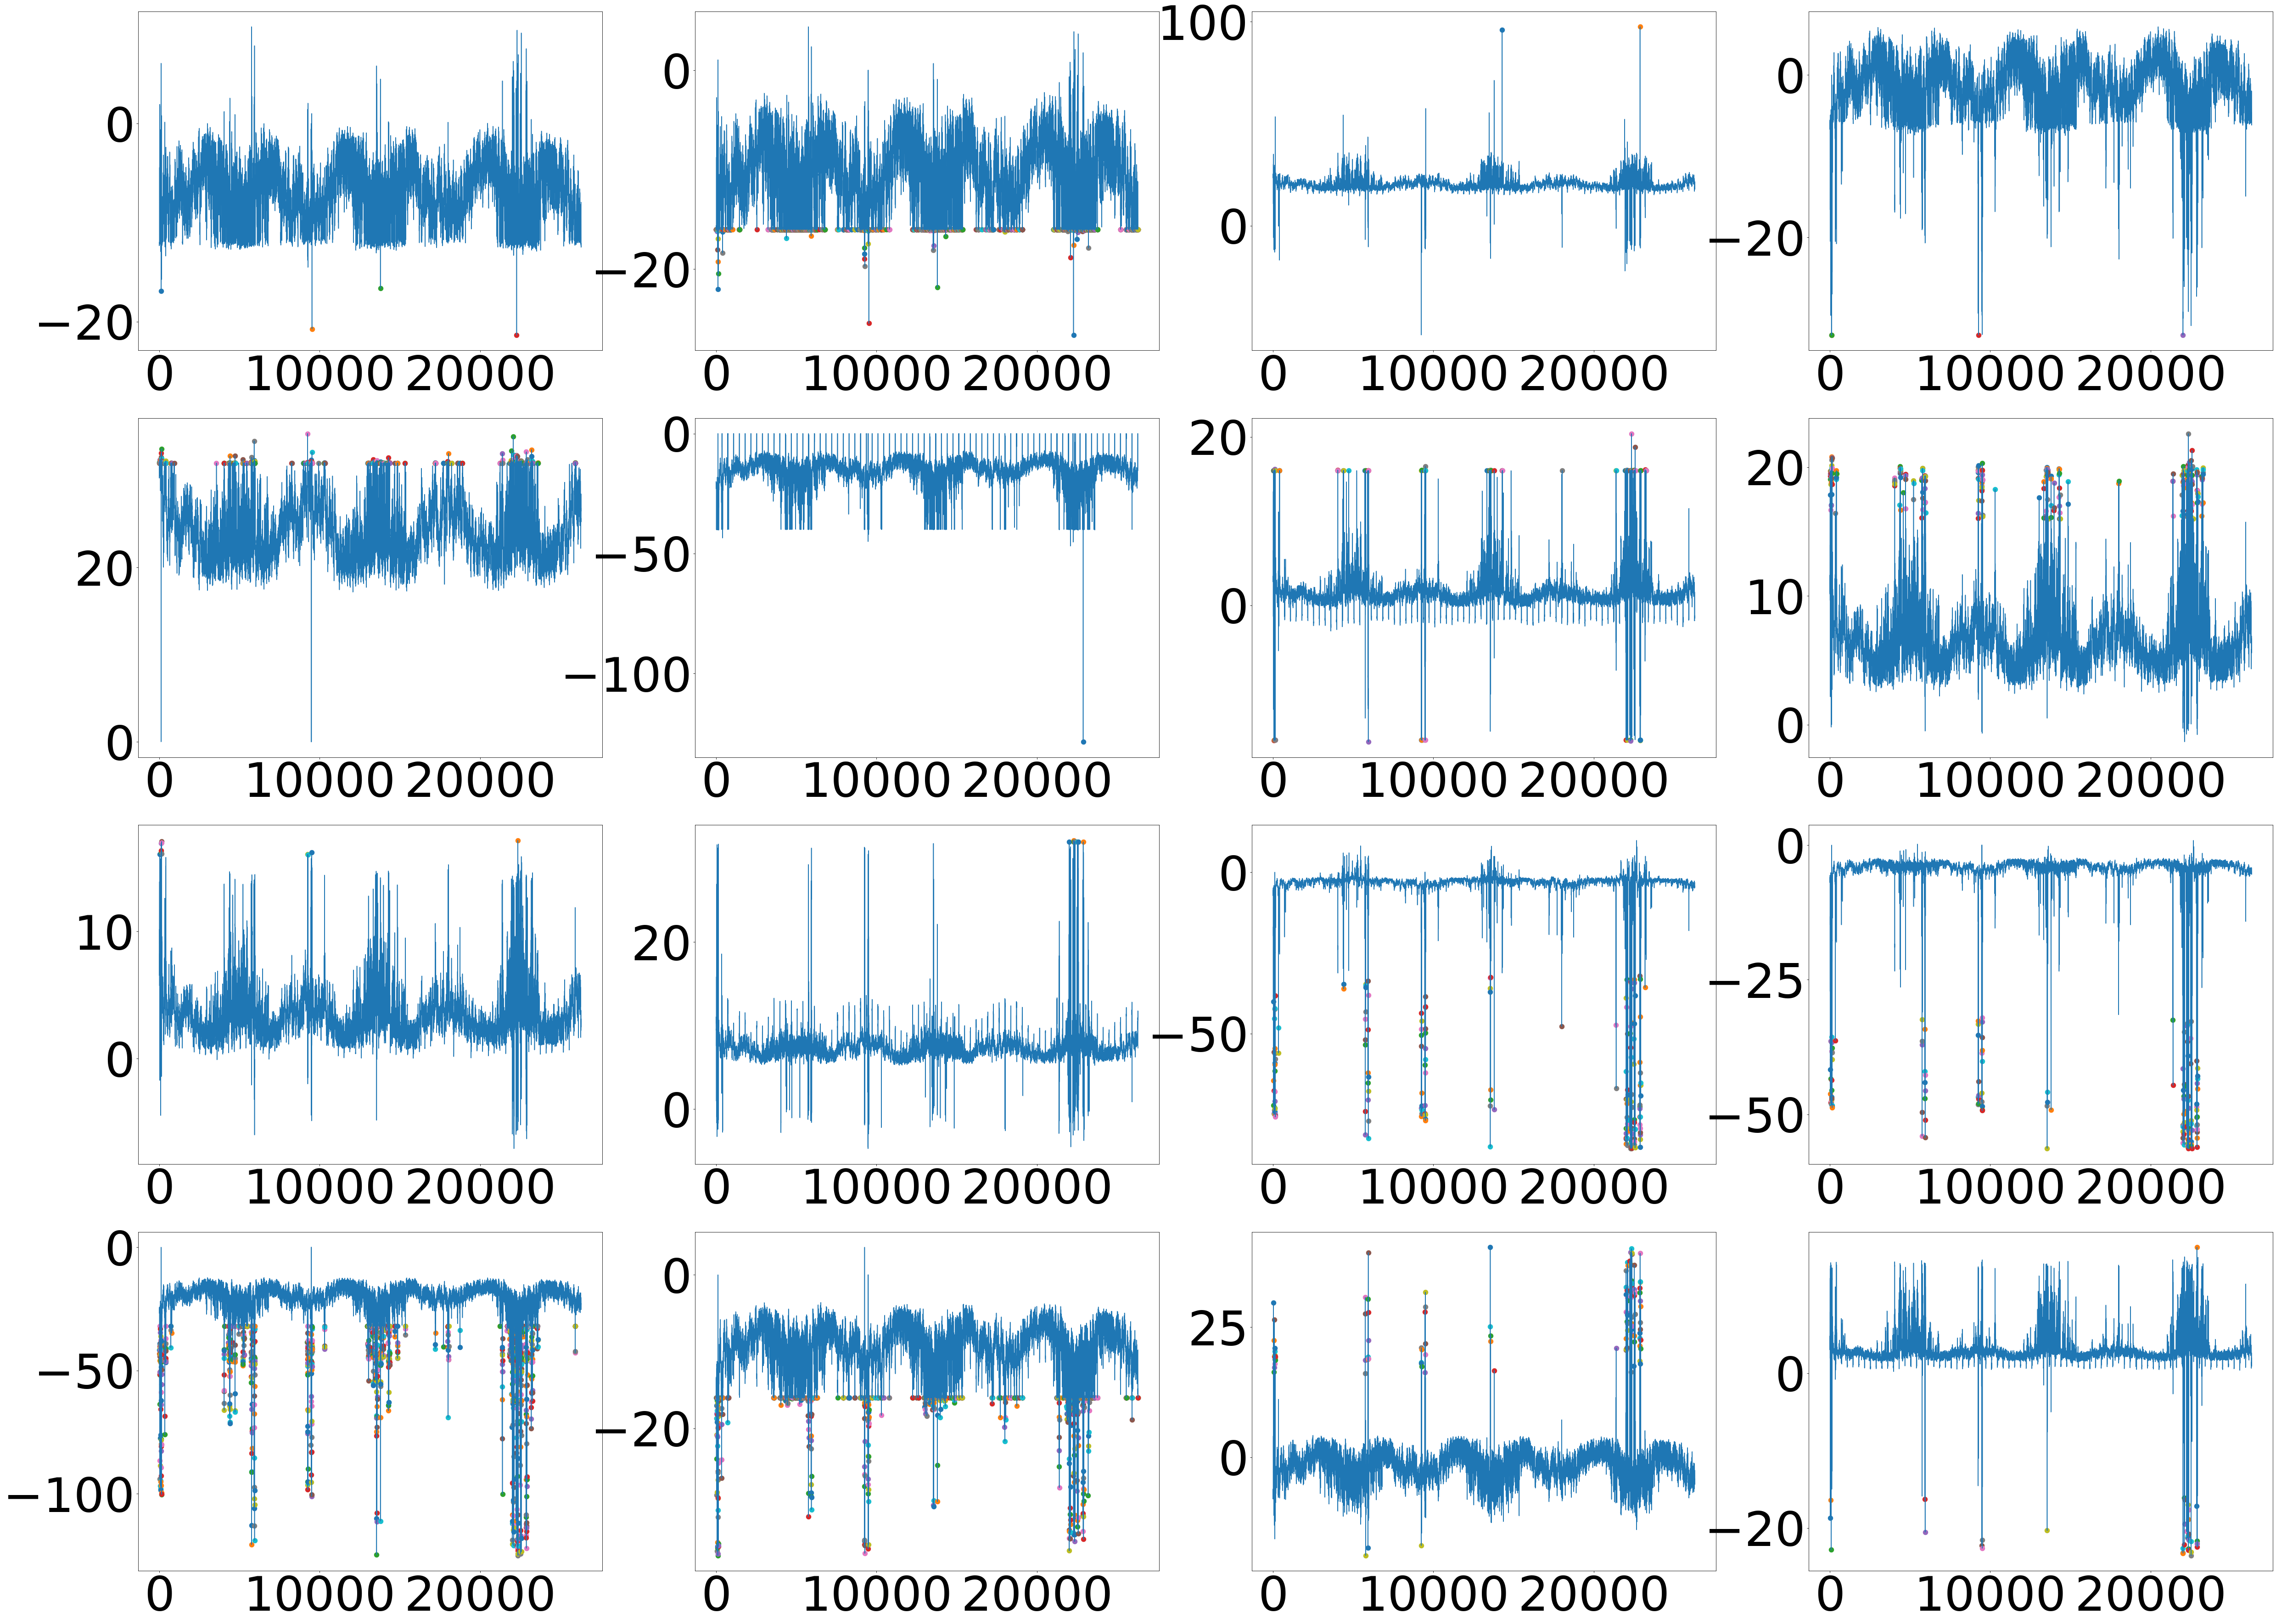

In [24]:
fig = plt.figure(figsize=(80, 60), dpi=75)
fig_num = 1
for i in congested_set:
    now = branch_result[i:i+1]
    now = now.to_numpy()[0]
    plt.subplot(4,4,fig_num)
    plt.plot(now)
    plt.tick_params(labelsize=100)
    for j in congested_point[i]:
        plt.scatter(j[0], j[1], s=100)
    fig_num += 1
plt.show()

### 生成labels

In [7]:
labels = np.zeros(branch_result.shape)
for time in range(branch_result.shape[1]):
    for line_num in range(branch_result.shape[0]):
        if abs(branch_result[time][line_num]) > branch_limitation[0][line_num]:
            labels[line_num][time] = 1

### 对拥堵线路异常值处理

In [8]:
# def handle_abnormal_value(samples):
#     for i in range(len(samples)):
#         if int(samples[i]) == 0:
#             samples[i] = samples.mean()
#     return samples


# fig = plt.figure(figsize=(80, 60), dpi=75)
# fig_num = 1
# for line in congested_set:
#     now = branch_info[line:line+1]
#     now = now.to_numpy()[0]
#     now = handle_abnormal_value(now)
#     file_name = str(line) + '.csv'
#     np.savetxt(file_name, now, delimiter=",")
#     plt.subplot(3,2,fig_num)
#     plt.plot(now)
#     plt.tick_params(labelsize=100)
#     for j in congested_point[line]:
#         plt.scatter(j[0], j[1], s=100)
#     fig_num += 1
# plt.show()

In [9]:
l = 8760+8760

In [14]:
train_set = branch_result.T[:l].T
test_set = branch_result.T[l:].T
print(train_set.shape)
print(test_set.shape)

(41, 17520)
(41, 8784)


In [15]:
train_set.to_csv('bus30_train.csv', index=False, header=None)
test_set.to_csv('bus30_test.csv', index=False, header=None)

In [16]:
train_label = pd.DataFrame(labels).T[:l].T
test_label = pd.DataFrame(labels).T[l:].T
print(train_label.shape)
print(test_label.shape)

(41, 17520)
(41, 8784)


In [17]:
train_label.to_csv('bus30_train_label.csv', index=False, header=None)
test_label.to_csv('bus30_test_label.csv', index=False, header=None)